# Interactive Data Exploration with Vertex AI Workbench

In this lab you will learn the process of analyzing a dataset stored in BigQuery using Vertex AI Workbench to perform queries and present the data using various statistical plotting techniques. The analysis will help you discover patterns in the data that will allow you to predict probable arrival time delays given the initial flight details and actual departure time.

Vertex AI Workbench is a powerful interactive tool created to explore, analyze, transform and visualize data and build machine learning models on Google Cloud. It runs on Compute Engine and connects easily to multiple cloud services so you can focus on your data science tasks.

BigQuery is a RESTful web service that enables interactive analysis of massive datasets working in conjunction with Google Storage.

The dataset that is used provides historic information about internal flights in the United States retrieved from the US Bureau of Transport Statistics website. This dataset can be used to demonstrate a wide range of data science concepts and techniques.

## Objectives

* Create a Notebook instance.
* Use Pandas and Seaborn to visualize Bigquery data.
* Iterate through the analysis process to refine the relationship between departure delays and arrival delays.

You can access the lab at [here](https://www.cloudskillsboost.google/focuses/1162?parent=catalog).

# Task 1. Exploratory data analysis in Vertex AI Workbench

 ## Import Modules
 
 Import the necessary modules and initialize a BigQuery client. 
 
 The BigQuery client will be used to send and receive messages from the BigQuery API.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from google.cloud import bigquery
bq = bigquery.Client()

## Jupyter Magic

Jupyter magics provide a mechanism to run a wide variety of languages, and ways to add some more. The BigQuery Python package has added a few magics to make the interaction with Google Cloud Platform convenient.

For example, you can run a query on your BigQuery table using the `%%bigquery` magic environment that comes with Vertex AI Workbench.

In [2]:
%%bigquery
SELECT COUNTIF(arr_delay >= 15) / COUNT(arr_delay) AS frac_delayed FROM dsongcp.flights_tzcorr

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.38s/rows]


frac_delayed
0      0.186111

## Calls to BigQuery

You can also query BigQuery directly with the `Python` library.

In [3]:
sql = 'SELECT COUNTIF(arr_delay >= 15) / COUNT(arr_delay) AS frac_delayed FROM dsongcp.flights_tzcorr'
bq.query(sql).to_dataframe()

frac_delayed
0      0.186111

# Basic Statistics

For a high-level view, draw a Probability Distribution Function (PDF) of different arrival delays. In a Notebook, assign the output of a cell magic query to a variable, in this case `df`:

In [4]:
%%bigquery df
SELECT ARR_DELAY, DEP_DELAY FROM dsongcp.flights_tzcorr WHERE DEP_DELAY >= 10

Downloading: 100%|██████████| 1294778/1294778 [00:01<00:00, 838767.13rows/s]


In [5]:
type(df)
df.describe()

ARR_DELAY     DEP_DELAY
count  1.286778e+06  1.294778e+06
mean   4.611797e+01  5.094516e+01
std    6.360700e+01  6.151423e+01
min   -7.800000e+01  1.000000e+01
25%    1.100000e+01  1.700000e+01
50%    2.700000e+01  3.000000e+01
75%    5.900000e+01  6.100000e+01
max    1.971000e+03  1.988000e+03

The `DataFrame.describe()` function reports the core statistics for the DataFrame returned by the query.

## Plotting Distributions

Beyond just the statistical capabilities of Pandas, you can also pass Pandas dataframes and underlying numpy arrays to plotting libraries like seaborn.

Now we will display a Seaborn violin chart. This shows the distribution dataframe that contains the sample of the arrival delay for flights that depart more than 10 minutes late:

(-50.0, 300.0)

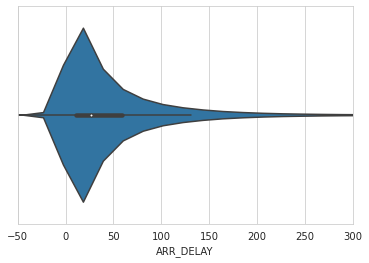

In [6]:
sns.set_style("whitegrid")
ax = sns.violinplot(data=df, x='ARR_DELAY', inner='box', orient='h')
ax.axes.set_xlim(-50, 300)

A violin plot is a kernel density plot, which is an estimate of the PDF. Notice that even though the distribution peaks around 10 minutes, deviations around this peak are skewed toward larger delays, rather than the smaller ones. Also, there is only one peak—the distribution.

Run a query comparing the violin plot for flights that depart more than 10 minutes late with the violin plot for flights that depart less than 10 minutes late. Zoom in on the *x*-axis close to your 15-minute threshold.

In [7]:
%%bigquery df
SELECT ARR_DELAY, DEP_DELAY FROM dsongcp.flights_tzcorr

Downloading: 100%|██████████| 5819079/5819079 [00:02<00:00, 2000344.74rows/s]


Create a new column in the Pandas dataframe that is either `True` or `False`, depending on whether the flight departed less than 10 minutes late:

In [8]:
df['ontime'] = df['DEP_DELAY'] < 10
df[df['ARR_DELAY'] > 0].head()

ARR_DELAY  DEP_DELAY  ontime
0       45.0       39.0   False
1       42.0       52.0   False
2       42.0       44.0   False
3       39.0       52.0   False
4       23.0       21.0   False

Use a seaborn to graph this new Pandas dataframe:

(-50.0, 200.0)

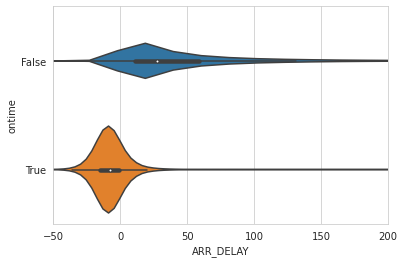

In [9]:
sns.set_style("whitegrid")
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', inner='box', orient='h')
ax.set_xlim(-50, 200)

The angular peak of the top violin plot indicates that the seaborn default smoothing was too coarse. Fix this by passing in a gridsize parameter. Note that the computation will take longer.

(-50.0, 200.0)

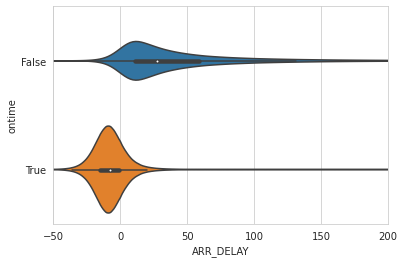

In [10]:
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', inner='box', orient='h', gridsize=1000)
ax.set_xlim(-50, 200)

This violin plot shows that the 10 minute departure delay threshold divides the dataset into two datasets, shown by the box plots in the center of these two distributions. Flights that depart 10 or more minutes late are asymmetrically distributed towards longer delay times. Flights that depart less than 10 minutes late are centered around the peak arrival time.

The long tail is a red flag. Further analyze the data to better understand what is really happening. In the next task, you use BigQuery to take a closer look at the range of delay times.

# Task 2. Quality Control

Although you could continue writing queries in the notebook, using BigQuery to query provides immediate feedback on syntax and logic errors.

In BigQuery, we will run the code below to obtain the average departure delay.

```sql
SELECT AVG(ARR_DELAY) AS arrival_delay FROM `dsongcp.flights_tzcorr` 
GROUP BY DEP_DELAY ORDER BY DEP_DELAY
```

Are the delays that span up to 20 hours significant? Yes because there are > 1100 

To refine the query and add some more data:

```sql
SELECT DEP_DELAY, AVG(ARR_DELAY) AS arrival_delay, COUNT(ARR_DELAY) AS numflights FROM `dsongcp.flights_tzcorr`
GROUP BY DEP_DELAY ORDER BY DEP_DELAY
```

The resulting table explains what’s going on. The first few rows have only a few flights each:

![](https://cdn.qwiklabs.com/txasgjSvHIWaBOGPIcxZ4capcmObERGqfFXI%2BgNqNlg%3D)

If you page ahead in the data, you see departure delay values of a few minutes have hundreds of thousands of flights:

![](https://cdn.qwiklabs.com/oBaz4eZi%2BZfj9carqUiUBfkkzYwzu2ykbfDB8PnmKzE%3D)

However, a delay of a few minutes is so small and can be considered insignificant. There is no reason to complicate our statistical modeling with insignificant values.

To eliminate these values from the dataset, filter the dataset so that you view only delay values within a particular range. For a dataset of a few hundred thousand examples, use a standard deviation range to focus on the you're interested in.

To apply a filter based on values within three times the standard deviation of the average value for departure delays:

```sql
SELECT 
    AVG(DEP_DELAY) - 3 * STDDEV(DEP_DELAY) AS filtermin, 
    AVG(DEP_DELAY) + 3 * STDDEV(DEP_DELAY) AS filtermax 
FROM `dsongcp.flights_tzcorr`
```

This yields a range of `-102` to `+121`. The query is still making some assumptions about the data values themselves and extreme outlier values can distort these calculations, even with hundreds of thousands of examples.

To avoid such an assumption, query using percentiles, omitting the top and bottom 5% of values:

```sql
SELECT APPROX_QUANTILES(DEP_DELAY, 20) FROM `dsongcp.flights_tzcorr`
```

This leads you to retain values in the range \[−9, 66\]. Regardless of how we find the range, though, the range is based on an assumption that unusually high and low values are outliers.

On datasets that number in the hundreds of thousands to millions of examples, thresholding your input data based on value is dangerous because you may be throwing out valuable nuance if there are sufficient examples of a delay of 150 minutes. It is worth modeling such a value regardless of how far off the mean it is.

To address this, use a filter that ensures that if there is a statistically significant number of flights with a specific delay, then it's' included, regardless of the actual delay value. For datasets of this size, you can use a filter that selects only values that have 370 or more examples. 370 examples is the sample size required to cover three standard deviations in a dataset with a normal distribution. A filter that selects only data points where you have at least 370 examples ensures that you have enough samples at each datapoint to satisfy the [three sigma rule](https://www.encyclopediaofmath.org/index.php/Three-sigma_rule). This gives you enough data to make reasonably robust predictions about each individual delay value.

```sql
SELECT
  DEP_DELAY,
  AVG(ARR_DELAY) AS arrival_delay,
  STDDEV(ARR_DELAY) AS stddev_arrival_delay,
  COUNT(ARR_DELAY) AS numflights
FROM `dsongcp.flights_tzcorr`
GROUP BY DEP_DELAY HAVING numflights > 370 ORDER BY DEP_DELAY
```

The output of the query is as shown in the image below.

![](https://media.discordapp.net/attachments/984655726406402088/993074177005342782/unknown.png?width=1440&height=435)

## Filtering Data On Occurrence Frequency

How different would the results be if you choose a different threshold? Look at the number of flights that are removed by different quality-control thresholds by looking at the slope of a linear model between arrival delay and departure delay.

We will now visualize this threshold data.

In [11]:
%%bigquery df
DECLARE total_flights INT64;
SET total_flights = (SELECT COUNT(*) FROM dsongcp.flights_tzcorr);

CREATE TEMPORARY FUNCTION linear_fit(NUM_TOTAL INT64, THRESH INT64)
RETURNS STRUCT<thresh INT64, num_removed INT64, lm FLOAT64> AS ((
    
    SELECT AS STRUCT 
        THRESH, 
        (NUM_TOTAL - SUM(numflights)) AS num_removed, 
        ROUND(AVG(arrival_delay * numflights) / AVG(dep_delay * numflights), 2
    ) AS lm 
    
    FROM (
    SELECT 
        DEP_DELAY,
        AVG(ARR_DELAY) AS arrival_delay,
        STDDEV(ARR_DELAY) AS stddev_arrival_delay,
        COUNT(ARR_DELAY) AS numflights
    FROM dsongcp.flights_tzcorr GROUP BY DEP_DELAY
    )
    
    WHERE numflights > THRESH
));

SELECT linear_fit(total_flights, 1000) stats
UNION ALL SELECT linear_fit(total_flights, 500)
UNION ALL SELECT linear_fit(total_flights, 370)
UNION ALL SELECT linear_fit(total_flights, 300)
UNION ALL SELECT linear_fit(total_flights, 200)
UNION ALL SELECT linear_fit(total_flights, 100)
UNION ALL SELECT linear_fit(total_flights, 22)
UNION ALL SELECT linear_fit(total_flights, 10)
UNION ALL SELECT linear_fit(total_flights, 5)
ORDER BY stats.thresh DESC

Downloading: 100%|██████████| 9/9 [00:03<00:00,  2.64rows/s]


In [12]:
df['stats'].map(lambda x: (x['thresh'], x['num_removed'], x['lm']))

0    (1000, 175873, 0.25)
1     (500, 143801, 0.34)
2     (370, 135518, 0.36)
3     (300, 129835, 0.38)
4      (200, 123640, 0.4)
5     (100, 115471, 0.43)
6      (22, 108247, 0.45)
7      (10, 106958, 0.46)
8       (5, 106319, 0.46)
Name: stats, dtype: object

As you remove fewer and fewer flights by decreasing the threshold. As you remove fewer and fewer flights by decreasing the threshold, the slope slowly changes. Thus, the differences in the model created for thresholds of 300, 370, or 500 are quite minor. However, that model is quite different from that created if the threshold were 5 or 10. The order of magnitude of the threshold matters, but perhaps not the exact value.

# Task 3. Distribution Of Arrival Delays

Create a variable with the BigQuery query based on the threshold level of 370 flights:

In [13]:
%%bigquery depdelay
SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) AS arrival_delay,
    STDDEV(ARR_DELAY) AS stddev_arrival_delay,
    COUNT(ARR_DELAY) AS numflights
FROM dsongcp.flights_tzcorr
GROUP BY DEP_DELAY HAVING numflights > 370 ORDER BY DEP_DELAY

Downloading: 100%|██████████| 240/240 [00:01<00:00, 200.37rows/s]


In [14]:
depdelay[:5]

DEP_DELAY  arrival_delay  stddev_arrival_delay  numflights
0      -23.0     -23.888646             11.432163         458
1      -22.0     -23.227488             12.590133         633
2      -21.0     -22.299781             11.558313         914
3      -20.0     -21.407821             12.066489        1432
4      -19.0     -20.430769             11.910134        1950

This provides the first five rows of the Pandas dataframe.

Plot this data to see what insight you can gain. Even though you've been using seaborn, Pandas has built-in plotting functions

Plot average arrival delay and the standard deviation for each delay:

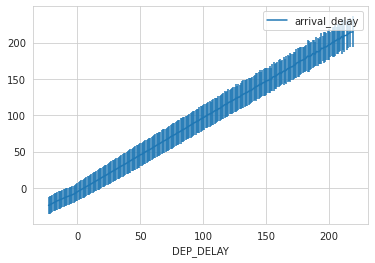

In [15]:
ax = depdelay.plot(
    kind='line',
    x='DEP_DELAY',
    y='arrival_delay',
    yerr='stddev_arrival_delay'
)

It looks like the relationship between departure delay and arrival delay is linear. The width of the standard deviation of the arrival delay is also constant, on the order of 10 minutes.

# Task 4. Applying a Probabilistic Decision Threshold

The purpose of all of this analysis has been to develop a model that allows you to predict whether a flight that has departed will arrive late. Specifically, a model that predicts whether a given flight has more than a 30% probability of arriving 15 or more minutes late.

Assume, in this case, the arrival delay distributions are normal. Based on that assumption you can use a [complementary cumulative distribution table](https://en.wikipedia.org/wiki/Standard_normal_table#Complementary_cumulative) to establish the *Z* value at which the probability is 30%. This turns out to be 0.52.

![](https://cdn.qwiklabs.com/GktUaBnFopr8KC4sTsZGjVp6DDZ3t%2BmYVyTEHK%2FE0iw%3D)

Use Pandas to plot the intersection of the 15 minute delay line with the 30% arrival delay probability line:

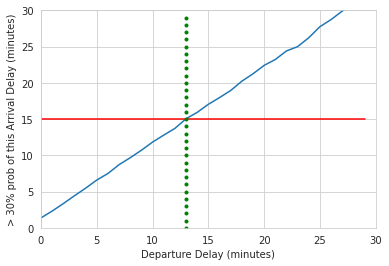

In [16]:
Z_30 = 0.52
depdelay['arr_delay_30'] = (Z_30 * depdelay['stddev_arrival_delay']) + depdelay['arrival_delay']

ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arr_delay_30', ax=ax, ylim=(0,30), xlim=(0,30), legend=False)

ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% prob of this Arrival Delay (minutes)')

x = np.arange(0, 30)
y = np.ones_like(x) * 15

ax.plot(x, y, color='r')

y = np.arange(0, 30)
x = np.ones_like(y) * 13

ax.plot(x, y, 'g.');

Your decision criterion translates to a departure delay of 13 minutes. If the departure delay is 13 minutes or more, the aircraft is more than 30% likely to be delayed by 15 minutes or more.

# Task 5. Deriving The Probability Distribution Function From The Data Itself

The analysis in the previous section used the number 0.52, which assumes that the distribution of flights at each departure delay is normal. What if you drop that assumption? You then must empirically determine the 30% likelihood at each departure delay.

Happily, we do have at least 370 flights at each departure delay (the joys of working with large datasets!), so we can compute the 30th percentile for each departure delay.

In [17]:
%%bigquery depdelay
SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY, 101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
FROM dsongcp.flights_tzcorr GROUP BY DEP_DELAY HAVING numflights > 370 ORDER BY DEP_DELAY

Downloading: 100%|██████████| 240/240 [00:01<00:00, 209.90rows/s]


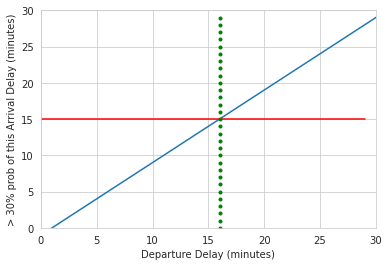

In [18]:
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay', ax=ax, ylim=(0,30), xlim=(0,30), legend=False)

ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% prob of this Arrival Delay (minutes)')

x = np.arange(0, 30)
y = np.ones_like(x) * 15

ax.plot(x, y, color='r')

y = np.arange(0, 30)
x = np.ones_like(y) * 16

ax.plot(x, y, 'g.')

From the chart, your decision threshold, without the assumption of normal distribution, is 16 minutes. If a flight is delayed by more than 16 minutes, there is a greater than 30% likelihood that the flight will arrive more than 15 minutes late.